# <h1 style="color:turquoise;">Deliverable2: Clasificación de texturas</h1>

## Dependencias

IMportamos las librerías necesarias: os, cv2, matplotlib, numpy, scikit-learn y skimage

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.regularizers import l2

## Dataset

En este dataset, tenemos 6 clases de texturas diferentes (lienzo, cojín, semillas de lino, arena, asiento y piedra) y para cada una de estas, disponemos de 40 imágenes.

El tamaño de las imágenes que contituyen este dataset es de 576x576 pixeles.

## Descriptores de la imagen 

Para el desarrollo de esta práctica se nos pide aplicar descriptores locales o globales sobre nuestro dataset para posteriormente aplicar algoritmos de machine learning de clasificación como pueden ser knn o MSV. 

## Descriptores

Para los descriptores globales, las texturas que presentan patrones repetitivos claros y fuertes contrastes como pueden ser las telas, GLCM sería una buena opción. HOG, podría ser útil si las texturas presentan patrones de bordes y orientaciones predominantes aunque presenta limitaciones para texturas irregulares como podría ser la piedra, la semilla de lino o la arena.

Por otro lado, tenemos los descriptores locales. Estos, son especialmente efectivos en escenarios de texturas complejas y heterogeneas. Detectan puntos clave o catacterísticas distintivas a nivel local, lo que es beneficioso para capturar detalles finos y variaciones dentro de la textura. Puede ser especialmente útil en texturas como la arena, las semillas de lino o la piedra, pudiendo ser así, superior a un descriptor global.

Como los descriptores locales presentan una dificultad añadida y, atendiendo a las características de las imágenes, emplearemos durante este primer punto, un modelo de descriptor global.

### Machine learning (KNN, SVM, etc)

En este primer bloque, se recorren cada una de las categorías de nuestro dataset con el objetivo de leer cada una de las imagenes y reescalarlas para que su posterior procesamiento sea computacionalmente eficiente y eficaz. Además, transformamos las listas *data* y *labels* a arrarys de numpy para su posterior procesamiento.

In [2]:
dataset_path = '.\\dataset\\'

data = []
labels = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path): 

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                image = cv2.resize(image, (128, 128))
                # image = cv2.resize(image, (256, 256))
                
                data.append(image)
                labels.append(category)
            else:
                print(f'Failed to read image: {image_path}')

data = np.array(data)
labels = np.array(labels)

print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Data shape: (240, 128, 128)
Labels shape: (240,)


Podemos ver en el resultado anterior que tenemos 240 imágenes de dimesnión 128x128 y 240 etiquetas.

Recorremos las imágenes y etiquetas del dataset con el fin de aplicar el descriptor HOG que nos proporcionará las carcaterísticas e imágenes HOG. Además, vamos a representas 6 imágenes para cada una de las cartegorías y representaremos su imagen de características asociada que proporciona el descriptor HOG.

Se han probado diferentes configuraciones de parámetros a la hora de aplicar el descriptor de HOG, pero finalmente nos declinamos por la siguiente configuración. Establecemos el `pixels_per_cell`=(8,8), para definir una celda de dimensión 8x8 pixeles enlas que se va a calcular el histograma de gradientes orientados. Los bloques contienen 2 celdas que se vana  normalizar juntas con la normalización 'L2-Hys' (`block_norm`); que es una variante de L2 con histeresis. Finalmente configuramos un total de 10 bins(`orientations`) , donde cada bin representa un rango de ángulos de gradiente, y el histograma de gradientes orientados se calcula para cada celda. Además, para tener imágenes HOG, establecemos el parámetro `visualice` a *True* junto a esto, obtenemos el vector de características de manera unidimentisonal con el parámetro `feature_vector`=*True*

HOG Features shape: (240, 9000)
HOG Labels shape: (240,)
Original Images shape: (240, 128, 128)


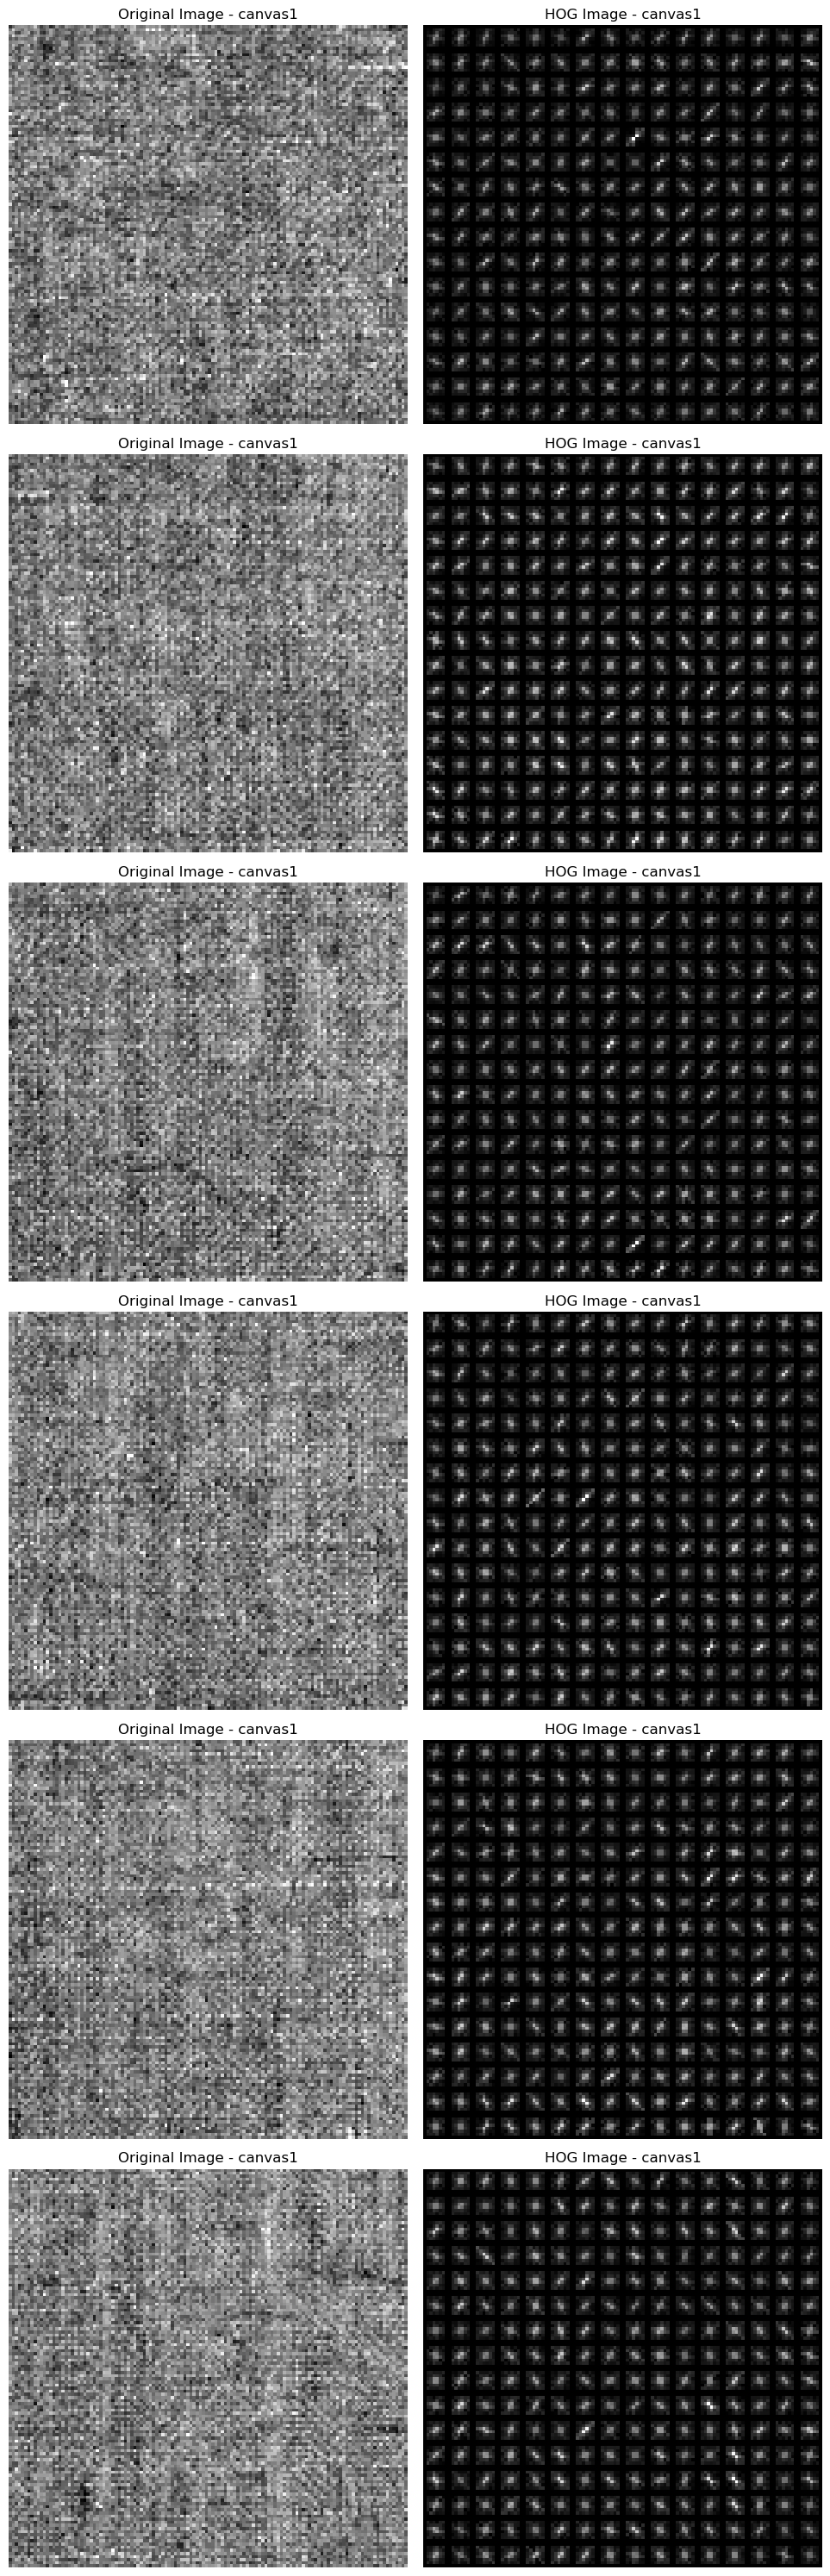

In [3]:
hog_features = []
original_images = []

selected_indices = [0, 1, 2, 3, 4, 5] 

fig, axes = plt.subplots(6, 2, figsize=(10, 30))

for i, (image, label) in enumerate(zip(data, labels)):
    features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys', orientations=10, feature_vector=True)
    
    hog_features.append(features)
    original_images.append(image)
    
    if i in selected_indices:
        idx = selected_indices.index(i)
        
        axes[idx, 0].imshow(image, cmap='gray')
        axes[idx, 0].set_title(f'Original Image - {label}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(hog_image, cmap='gray')
        axes[idx, 1].set_title(f'HOG Image - {label}')
        axes[idx, 1].axis('off')

hog_features = np.array(hog_features)
original_images = np.array(original_images)

print(f'HOG Features shape: {hog_features.shape}')
print(f'HOG Labels shape: {labels.shape}')
print(f'Original Images shape: {original_images.shape}')

plt.tight_layout()
plt.show()

Se tienen 240 imágenes donde cada imagen está definida por un vector de características de HOG de longitud 9000.

Se transformas los valores de las etiquetas numéricas a *strings* que posterior mente se emplearán en el método de clasificación.

In [4]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(f'Clases: {label_encoder.classes_}')

labels = encoded_labels
print(f'Updated Labels shape: {labels.shape}')

Clases: ['canvas1' 'cushion1' 'linsseeds1' 'sand1' 'seat2' 'stone1']
Updated Labels shape: (240,)


Para dividir el conjunto de datos en *train* y *test* de forma estratificada, se emplea el método `StratifiedShuffleSplit` y se establece que un 30% de los datos vana  ser de *test*

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=41)

for train_index, test_index in split.split(hog_features, labels):
    X_train, X_test = hog_features[train_index], hog_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    X_train_images, X_test_images = original_images[train_index], original_images[test_index]

y_train_images = y_train
y_test_images = y_test

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_train_images shape: {X_train_images.shape}')
print(f'X_test_images shape: {X_test_images.shape}')

X_train shape: (168, 9000)
X_test shape: (72, 9000)
y_train shape: (168,)
y_test shape: (72,)
X_train_images shape: (168, 128, 128)
X_test_images shape: (72, 128, 128)


168 imágenes de entrenamiento y 72 de *test*

Establecemos un grid para poder explorar diferentes configuraciones de parámetros para entrenar el modelo SVM. Se han hecho pruebas con otro modelo como KNN pero, el modelo SVM con un kernel radial ofrece mejores resultados. 

In [6]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
}

# Train SVM Classifier
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=0, cv=7)
grid_svm.fit(X_train, y_train)

# Obtener las mejores puntuaciones de validación cruzada
cv_results_svm = grid_svm.cv_results_
mean_accuracy_svm = cv_results_svm['mean_test_score'][grid_svm.best_index_]
std_accuracy_svm = cv_results_svm['std_test_score'][grid_svm.best_index_]

print(f'Mejores parámetros para SVM: {grid_svm.best_params_}')
print(f'Mejor precisión para SVM: {mean_accuracy_svm:.2f} ± {std_accuracy_svm:.2f}')

Mejores parámetros para SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor precisión para SVM: 0.92 ± 0.03


Finalmente se calculan las predicciones con la mejor configuración del clasificador SVM y se calcula la precisión de las predicciones y la matriz de confusión.

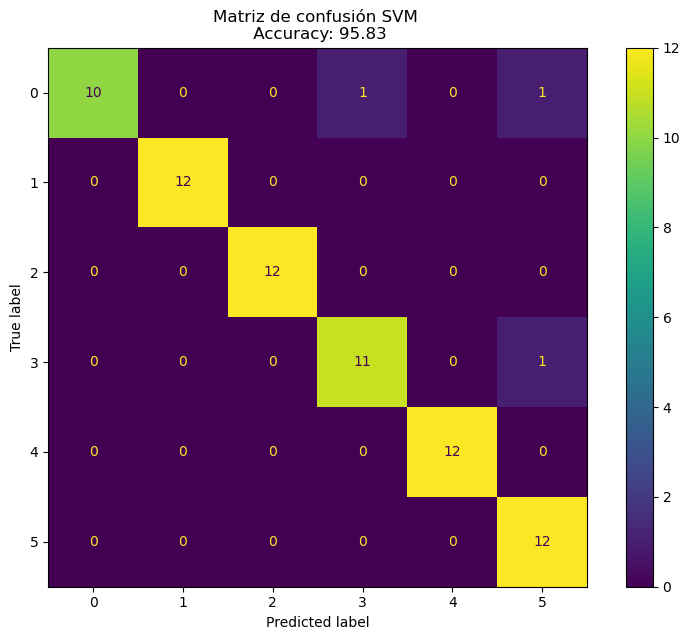

In [7]:
# Calculamos la predicción empleando la mejor configuración
y_pred_svm = grid_svm.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test)

cm_svm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots(figsize=(10, 7))

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=grid_svm.classes_)
disp_svm.plot(ax = ax)

plt.title(f'Matriz de confusión SVM \n Accuracy: {accuracy_svm * 100:.2f}')
plt.show()

### Fully connected network

En este bloque, se va a emplear el conjunto de características que hemos obtenido de aplicar los descriptores sobre nuestro conjunto de imágenes para entrenar una *fully connected network*. 

In [8]:
X_train = X_train.astype('float') 
X_test = X_test.astype('float') 
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

A continuación, se define nuestro modelo *fully connected network*. Este modelo, está compuesto por 6 capas densas, con funciones de activación relu. Cada capa densa presenta 256, 128, 128, 64, 32 y 6 neuronas. La capa final es una capa densa con 6 neuronas y activación softmax con el fin de realizar la clasificación multiclase. Finalemnte, mostramos la estructura de nuestra red neuronal mediante la sentencia `model.summary()`.

In [24]:
model = Sequential()
model.add(Dense(256, input_dim=9000, activation='relu', kernel_regularizer=l2(0.001))) 
model.add(Dense(128, activation='relu'))   
model.add(Dense(64, activation='relu')) 
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               2304256   
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 6)                 198       
                                                                 
Total params: 2,347,686
Trainable params: 2,347,686
Non-trainable params: 0
_________________________________________________________________


En el siguiente fragmento de código, establecemos el optimizador que se va a emplear al entrenar el modelo. Inicializamos tanto el optimizado Adam como el SGD, pero nos quedamos con Adam puesto que nos arroja mejores resultados. Como función de pérdida empleamos `categorical_crossentropy`, adecuado para problemas de multiclase y, se especifica el `accuracy` como métrica para evaluar el rendimiento del modelo

In [25]:
adam = Adam(learning_rate=0.001)
# sgd = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Se entrena el modelo

In [26]:
history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_test, y_test))

Epoch 1/20
6/6 [==============================] - 1s 54ms/step - loss: 2.5216 - accuracy: 0.1607 - val_loss: 2.2468 - val_accuracy: 0.1667
Epoch 2/20
6/6 [==============================] - 0s 27ms/step - loss: 2.1324 - accuracy: 0.3036 - val_loss: 1.9142 - val_accuracy: 0.4444
Epoch 3/20
6/6 [==============================] - 0s 26ms/step - loss: 1.7965 - accuracy: 0.5119 - val_loss: 1.6732 - val_accuracy: 0.6389
Epoch 4/20
6/6 [==============================] - 0s 9ms/step - loss: 1.5951 - accuracy: 0.6012 - val_loss: 1.6028 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 0s 9ms/step - loss: 1.4423 - accuracy: 0.6250 - val_loss: 1.3926 - val_accuracy: 0.6111
Epoch 6/20
6/6 [==============================] - 0s 9ms/step - loss: 1.2437 - accuracy: 0.6786 - val_loss: 1.2541 - val_accuracy: 0.6944
Epoch 7/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0883 - accuracy: 0.7202 - val_loss: 1.1770 - val_accuracy: 0.6111
Epoch 8/20
6/6 [===============

Evaluamos el modelo sobre el conjunto de datos `X_train` y `X_test`.

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

3/3 [==============================] - 0s 5ms/step - loss: 0.6249 - accuracy: 0.9028
Test Loss: 0.6249
Test Accuracy: 0.9028


Finalmnete, representamos gráficamente los resultados de nuestro modelo.

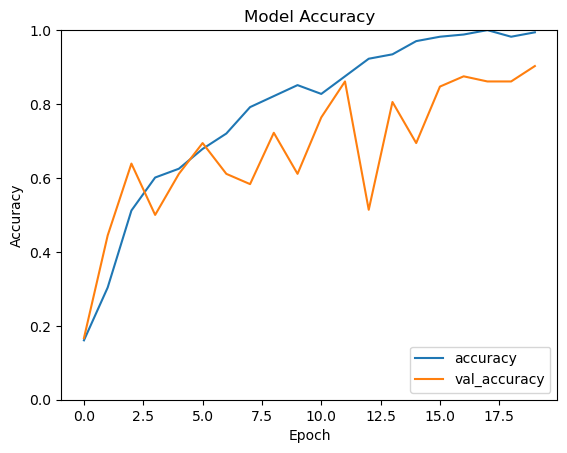

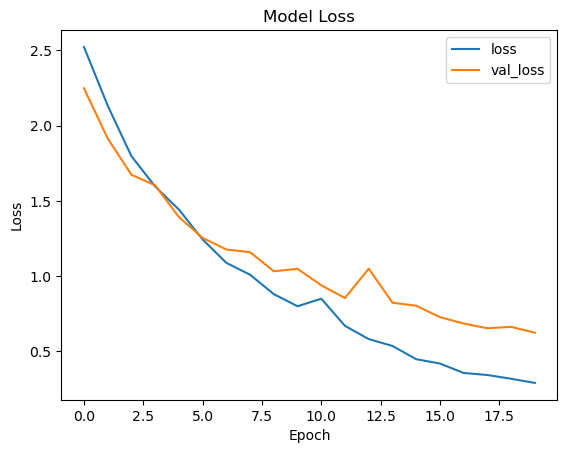

3/3 [==============================] - 0s 8ms/step


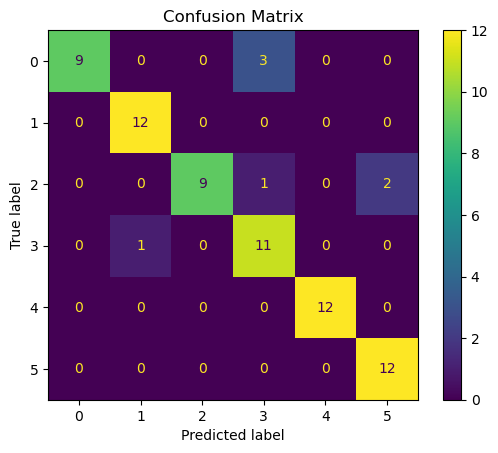

In [28]:
# Grafica la Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Grafica loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

y_pred = model.predict(X_test)

# Convertir las predicciones y las etiquetas verdaderas a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

## Imagen como vector

En este segundo bloque, en lugar de procesar las imágenes a través de las características extraidas con los descriptores, vamos a procesar las imágenes directamente. 

In [14]:
X_train_images = X_train_images.astype('float') /255.0
X_test_images = X_test_images.astype('float') / 255.0
y_train_images = to_categorical(y_train_images, num_classes=6)
y_test_images = to_categorical(y_test_images, num_classes=6)

Proponemos una red neuronal secuencial a la que llamaremos `model2`. Para procesar directamente las imágenes empleamos una primera capa `Flatten` que aplanará las entradas de tamaño `(128,128)` en un vector unidimentsional. Luego, empleamos tres capas neuronales densas con 128 neuronas, funcion de activación `Relu` y un `kernel_regularizer=l2(0.001)` para intentar prevenir sobreajustes. Después de cada capa densa, se añade una capa de normalización por lotes (`BatchNormalization`) para acelerar el entrenamiento y mejorar la estabilidad, seguidas de una capa (`Dropout`) con una tasa de 0.5 para reducir de nuevo, la probabilidad de sobreajuste. Finalmente, el modelo incluye una capa de 6 neuronas y una función de activación `Softmax` para poder realizar la multiclasificación

In [15]:
model2 = Sequential()
model2.add(Flatten(input_shape=(128, 128)))
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(6, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               2097280   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

En el siguiente fragmento de código, establecemos el optimizador que se va a emplear al entrenar el modelo. Inicializamos tanto el optimizado Adam como el SGD, pero nos quedamos con Adam puesto que nos arroja mejores resultados. Como función de pérdida empleamos `categorical_crossentropy`, adecuado para problemas de multiclase y, se especifica el `accuracy` como métrica para evaluar el rendimiento del modelo

In [16]:
adam = Adam(learning_rate=0.001)
# sgd = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Se entrena el modelo con 15 epoch y un tamaño de batch de 20

In [17]:
history2 = model2.fit(X_train_images, y_train_images, epochs=10, batch_size=4, validation_data=(X_test_images, y_test_images))

Epoch 1/10
42/42 [==============================] - 1s 11ms/step - loss: 3.3529 - accuracy: 0.2024 - val_loss: 18.1647 - val_accuracy: 0.1667
Epoch 2/10
42/42 [==============================] - 0s 9ms/step - loss: 3.2343 - accuracy: 0.1548 - val_loss: 13.9562 - val_accuracy: 0.1667
Epoch 3/10
42/42 [==============================] - 0s 8ms/step - loss: 3.0794 - accuracy: 0.1548 - val_loss: 12.7358 - val_accuracy: 0.1667
Epoch 4/10
42/42 [==============================] - 0s 7ms/step - loss: 2.9039 - accuracy: 0.1786 - val_loss: 7.8023 - val_accuracy: 0.1667
Epoch 5/10
42/42 [==============================] - 0s 8ms/step - loss: 2.9144 - accuracy: 0.2024 - val_loss: 4.6210 - val_accuracy: 0.1667
Epoch 6/10
42/42 [==============================] - 0s 8ms/step - loss: 2.8186 - accuracy: 0.1905 - val_loss: 3.1937 - val_accuracy: 0.1667
Epoch 7/10
42/42 [==============================] - 0s 7ms/step - loss: 2.9021 - accuracy: 0.1726 - val_loss: 2.7938 - val_accuracy: 0.1667
Epoch 8/10
42/42

Evaluamos nuestro modelo2 sobre el conjunto de `X_test_images` e `y_test_images`

In [18]:
test_loss, test_accuracy = model2.evaluate(X_test_images, y_test_images)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

3/3 [==============================] - 0s 3ms/step - loss: 2.3554 - accuracy: 0.1250
Test Loss: 2.3554
Test Accuracy: 0.1250


Representamos lo resultados obtenidos

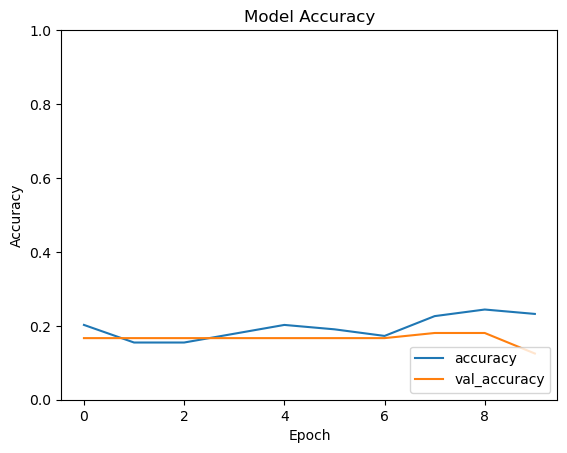

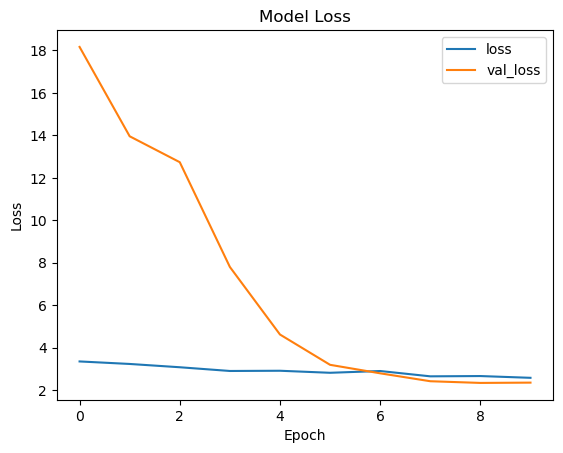

3/3 [==============================] - 0s 2ms/step


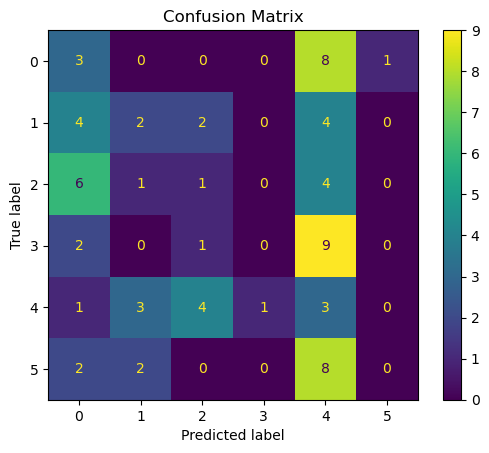

In [19]:
# Grafica Accuracy
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Grafica Loss
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

y_pred = model2.predict(X_test_images)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_images, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

## CNN

En este punto, vamos a utilizar redes neuronales convolucionales para clasificar cuya entrada son las imágenes.

In [20]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=(128,128,1)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(6, activation='softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 64)               

Para el proceso de entrenamiento seleccionamos 15 epoch y el tamaño del batch 8.

In [21]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train_images, y_train_images, epochs=15, batch_size=7, validation_data=(X_test_images, y_test_images))

Epoch 1/15
24/24 [==============================] - 6s 18ms/step - loss: 2.0198 - accuracy: 0.1429 - val_loss: 1.7452 - val_accuracy: 0.1667
Epoch 2/15
24/24 [==============================] - 0s 10ms/step - loss: 1.7062 - accuracy: 0.2500 - val_loss: 1.5401 - val_accuracy: 0.3333
Epoch 3/15
24/24 [==============================] - 0s 10ms/step - loss: 1.4080 - accuracy: 0.3929 - val_loss: 1.2736 - val_accuracy: 0.6806
Epoch 4/15
24/24 [==============================] - 0s 10ms/step - loss: 1.2174 - accuracy: 0.4881 - val_loss: 1.0123 - val_accuracy: 0.6667
Epoch 5/15
24/24 [==============================] - 0s 9ms/step - loss: 0.9330 - accuracy: 0.6548 - val_loss: 0.9437 - val_accuracy: 0.5972
Epoch 6/15
24/24 [==============================] - 0s 10ms/step - loss: 0.7234 - accuracy: 0.7202 - val_loss: 1.0677 - val_accuracy: 0.5278
Epoch 7/15
24/24 [==============================] - 0s 10ms/step - loss: 0.6104 - accuracy: 0.7560 - val_loss: 0.7701 - val_accuracy: 0.5556
Epoch 8/15
24/

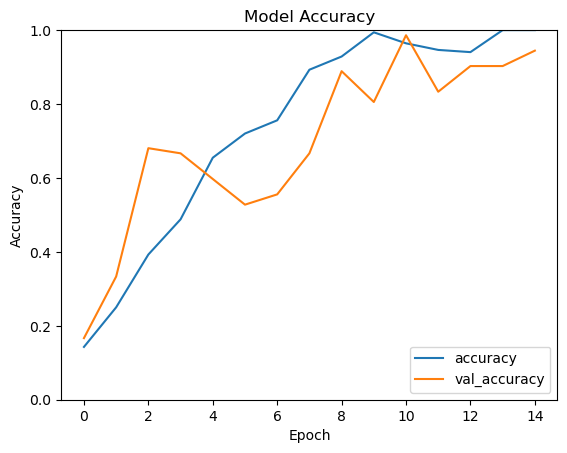

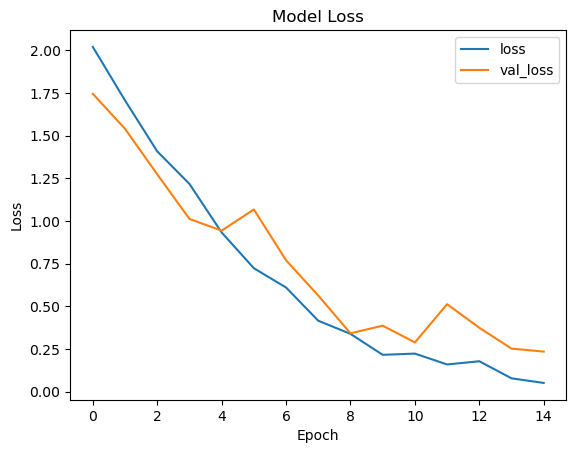

3/3 [==============================] - 0s 41ms/step


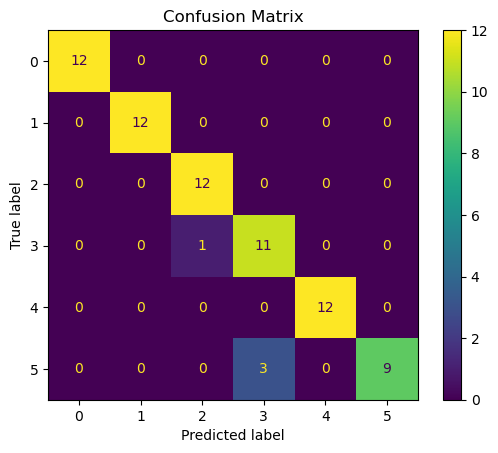

In [22]:
# Grafica Accuracy
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Grafica Loss
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

y_pred = model3.predict(X_test_images)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_images, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()